In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import os

In [ ]:
dir = os.getcwd()
project_root = os.path.abspath(os.path.join(dir, '..'))
data_root = os.path.join(project_root, 'data')
df = pd.read_csv(filepath_or_buffer=os.path.join(data_root, 'f1_data.csv'))

df.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,TrackTemp,Rainfall,WindSpeed,RoundNumber
0,0 days 01:12:57.726000,NOR,4,0 days 00:01:57.099000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:20.913000,...,124,1.0,False,NaN,False,False,19.2,False,3.9,1
1,0 days 01:12:57.726000,DOO,7,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,124,NaN,False,NaN,True,False,19.2,False,3.9,1
2,0 days 01:12:57.726000,HAD,6,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,124,NaN,False,NaN,True,False,19.2,False,3.9,1
3,0 days 01:12:57.726000,SAI,55,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,124,NaN,False,NaN,True,False,19.2,False,3.9,1
4,0 days 01:13:00.002000,VER,1,0 days 00:01:59.392000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:20.705000,...,124,2.0,False,NaN,False,False,19.2,False,3.9,1


In [192]:
df.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'TrackTemp', 'Rainfall', 'WindSpeed',
       'RoundNumber'],
      dtype='object')

In [193]:
cols_to_save = ['DriverNumber', 'LapTime', 'LapNumber', 'SpeedST', 'Compound', 'TyreLife', 'Team', 'TrackStatus', 'TrackTemp', 'Rainfall', 'WindSpeed', 'RoundNumber']
df = df[cols_to_save].copy()
df['LapTime'] = pd.to_timedelta(df['LapTime'])
df['LapTime'] = df['LapTime'].dt.total_seconds()
df['SpeedST'] = df.groupby('DriverNumber')['SpeedST'].transform(lambda x: x.ffill().bfill())

In [194]:
df.head()

,DriverNumber,LapTime,LapNumber,SpeedST,Compound,TyreLife,Team,TrackStatus,TrackTemp,Rainfall,WindSpeed,RoundNumber
0,4,117.099,1.0,227.0,INTERMEDIATE,1.0,McLaren,124,19.2,False,3.9,1
1,7,NaN,1.0,318.0,INTERMEDIATE,1.0,Alpine,124,19.2,False,3.9,1
2,6,NaN,1.0,319.0,INTERMEDIATE,1.0,Racing Bulls,124,19.2,False,3.9,1
3,55,NaN,1.0,321.0,INTERMEDIATE,1.0,Williams,124,19.2,False,3.9,1
4,1,119.392,1.0,215.0,INTERMEDIATE,1.0,Red Bull Racing,124,19.2,False,3.9,1


In [195]:
df = df.dropna()

In [196]:
max_laps = df.groupby('RoundNumber')['LapNumber'].transform('max')
df['FuelLevel'] = max_laps - df['LapNumber']
df.head()

,DriverNumber,LapTime,LapNumber,SpeedST,Compound,TyreLife,Team,TrackStatus,TrackTemp,Rainfall,WindSpeed,RoundNumber,FuelLevel
0,4,117.099,1.0,227.0,INTERMEDIATE,1.0,McLaren,124,19.2,False,3.9,1,56.0
4,1,119.392,1.0,215.0,INTERMEDIATE,1.0,Red Bull Racing,124,19.2,False,3.9,1,56.0
5,81,120.807,1.0,226.0,INTERMEDIATE,1.0,McLaren,124,19.2,False,3.9,1,56.0
6,63,124.644,1.0,207.0,INTERMEDIATE,1.0,Mercedes,124,19.2,False,3.9,1,56.0
7,16,128.480,1.0,191.0,INTERMEDIATE,1.0,Ferrari,124,19.2,False,3.9,1,56.0


In [197]:
df.dtypes

DriverNumber      int64
LapTime         float64
LapNumber       float64
SpeedST         float64
Compound         object
TyreLife        float64
Team             object
TrackStatus       int64
TrackTemp       float64
Rainfall           bool
WindSpeed       float64
RoundNumber       int64
FuelLevel       float64
dtype: object

In [198]:
df['DriverNumber'] = df['DriverNumber'].astype('category')
df['Compound'].unique()

array(['INTERMEDIATE', 'MEDIUM', 'HARD', 'SOFT'], dtype=object)

In [199]:
# deleting all laps with yellow or red flags (significantly impacts time)
df = df[df['TrackStatus'] == 1]
df['TrackStatus'].unique()

array([1])

In [200]:
quali = pd.read_csv('./f1_quali_data.csv')
quali

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,RoundNumber
0,0 days 00:18:10.446000,NOR,4,0 days 00:01:16.003000,2.0,1.0,NaN,NaN,0 days 00:00:26.383000,0 days 00:00:17.285000,...,McLaren,0 days 00:16:54.443000,NaN,1,NaN,NaN,NaN,False,True,1
1,0 days 00:23:24.968000,NOR,4,0 days 00:01:15.912000,5.0,2.0,NaN,NaN,0 days 00:00:26.463000,0 days 00:00:17.116000,...,McLaren,0 days 00:22:09.056000,NaN,1,NaN,NaN,NaN,False,True,1
2,0 days 00:42:08.476000,NOR,4,0 days 00:01:15.556000,10.0,4.0,NaN,NaN,0 days 00:00:26.104000,0 days 00:00:17.122000,...,McLaren,0 days 00:40:52.920000,NaN,1,NaN,NaN,NaN,False,True,1
3,0 days 00:53:23.470000,NOR,4,0 days 00:01:15.415000,13.0,5.0,NaN,NaN,0 days 00:00:26.194000,0 days 00:00:17.030000,...,McLaren,0 days 00:52:08.055000,NaN,1,NaN,NaN,NaN,False,True,1
4,0 days 01:03:42.907000,NOR,4,0 days 00:01:15.921000,16.0,6.0,NaN,NaN,0 days 00:00:26.127000,0 days 00:00:17.057000,...,McLaren,0 days 01:02:26.986000,NaN,1,NaN,NaN,NaN,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,0 days 00:22:23.710000,GAS,10,0 days 00:01:23.522000,5.0,2.0,NaN,NaN,0 days 00:00:17.076000,0 days 00:00:36.200000,...,Alpine,0 days 00:21:00.188000,NaN,1,NaN,NaN,NaN,False,True,24
2156,0 days 00:31:40.354000,GAS,10,0 days 00:01:23.468000,8.0,3.0,NaN,NaN,0 days 00:00:17.050000,0 days 00:00:36.078000,...,Alpine,0 days 00:30:16.886000,NaN,1,NaN,NaN,NaN,False,True,24
2157,0 days 00:16:52.441000,COL,43,0 days 00:01:24.468000,2.0,1.0,NaN,NaN,0 days 00:00:17.309000,0 days 00:00:36.477000,...,Alpine,0 days 00:15:27.973000,NaN,1,NaN,NaN,NaN,False,True,24
2158,0 days 00:22:58.066000,COL,43,0 days 00:01:23.947000,5.0,2.0,NaN,NaN,0 days 00:00:17.138000,0 days 00:00:36.356000,...,Alpine,0 days 00:21:34.119000,NaN,1,NaN,NaN,NaN,False,True,24


In [201]:
quali['LapTime'] = pd.to_timedelta(quali['LapTime'])
quali['LapTime'] = quali['LapTime'].dt.total_seconds()
best_quali = quali.groupby('RoundNumber')['LapTime'].min().rename('QualiBest')
best_quali

RoundNumber
1      75.096
2      90.641
3      86.983
4      89.841
5      87.294
6      86.204
7      74.670
8      69.954
9      71.546
10     70.899
11     63.971
12     84.892
13    100.562
14     74.890
15     68.662
16     78.792
17    101.117
18     89.158
19     92.510
20     75.586
21     69.511
23     79.387
24     82.207
Name: QualiBest, dtype: float64

In [202]:
df = df.merge(best_quali, on='RoundNumber', how='left')
df['Target'] = df['LapTime'] / df['QualiBest']

In [203]:
df = df.sort_values(by=['RoundNumber', 'LapNumber', 'DriverNumber'])
df

,DriverNumber,LapTime,LapNumber,SpeedST,Compound,TyreLife,Team,TrackStatus,TrackTemp,Rainfall,WindSpeed,RoundNumber,FuelLevel,QualiBest,Target
1,1,96.830,8.0,245.0,INTERMEDIATE,8.0,Red Bull Racing,1,19.1,False,3.4,1,49.0,75.096,1.289416
0,4,96.278,8.0,276.0,INTERMEDIATE,8.0,McLaren,1,19.1,False,3.4,1,49.0,75.096,1.282066
13,5,100.265,8.0,242.0,INTERMEDIATE,8.0,Kick Sauber,1,19.1,False,3.4,1,49.0,75.096,1.335158
8,10,98.441,8.0,232.0,INTERMEDIATE,8.0,Alpine,1,19.1,False,3.4,1,49.0,75.096,1.310869
12,12,98.729,8.0,240.0,INTERMEDIATE,8.0,Mercedes,1,19.1,False,3.4,1,49.0,75.096,1.314704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21532,44,89.511,58.0,310.0,MEDIUM,27.0,Ferrari,1,29.0,False,0.8,24,0.0,82.207,1.088849
21537,55,90.046,58.0,316.0,HARD,40.0,Williams,1,29.0,False,0.8,24,0.0,82.207,1.095357
21529,63,88.853,58.0,312.0,HARD,44.0,Mercedes,1,29.0,False,0.8,24,0.0,82.207,1.080845
21525,81,88.074,58.0,315.0,MEDIUM,17.0,McLaren,1,29.0,False,0.8,24,0.0,82.207,1.071369


In [204]:
df = df.drop(columns='TrackStatus')
# first lap of the race is abnormally slow so we will get rid of it
df = df[df['LapNumber'] > 1].copy()

In [205]:
df["Target"].describe()
df.sort_values("Target", ascending=False).head(20)

,DriverNumber,LapTime,LapNumber,SpeedST,Compound,TyreLife,Team,TrackTemp,Rainfall,WindSpeed,RoundNumber,FuelLevel,QualiBest,Target
16391,44,128.668,61.0,189.0,SOFT,18.0,Ferrari,33.6,False,1.4,18,1.0,89.158,1.443146
16,87,102.054,8.0,218.0,INTERMEDIATE,4.0,Haas F1 Team,19.1,False,3.4,1,49.0,75.096,1.358981
4385,5,117.049,30.0,181.0,HARD,7.0,Kick Sauber,36.0,False,1.1,6,27.0,86.204,1.357814
458,22,100.978,46.0,256.0,MEDIUM,13.0,Racing Bulls,19.3,True,1.8,1,11.0,75.096,1.344652
15,30,100.582,8.0,230.0,INTERMEDIATE,7.0,Red Bull Racing,19.1,False,3.4,1,49.0,75.096,1.339379
14,31,100.522,8.0,217.0,INTERMEDIATE,4.0,Haas F1 Team,19.1,False,3.4,1,49.0,75.096,1.338580
13,5,100.265,8.0,242.0,INTERMEDIATE,8.0,Kick Sauber,19.1,False,3.4,1,49.0,75.096,1.335158
462,30,99.457,46.0,263.0,MEDIUM,13.0,Red Bull Racing,19.3,True,1.8,1,11.0,75.096,1.324398
10154,23,111.991,11.0,310.0,INTERMEDIATE,11.0,Williams,23.3,True,1.1,12,41.0,84.892,1.319217
11,27,98.959,8.0,230.0,INTERMEDIATE,8.0,Kick Sauber,19.1,False,3.4,1,49.0,75.096,1.317767


In [206]:
num_cols = ["LapTime","Target","SpeedST","TyreLife","TrackTemp","WindSpeed","FuelLevel","QualiBest","LapNumber"]
print(df[num_cols].describe(percentiles=[.001,.01,.05,.5,.95,.99,.999]).T)

             count        mean        std         min        0.1%          1%  \
LapTime    21315.0   87.660249  10.555803   67.924000   68.759512   69.960000   
Target     21315.0    1.094949   0.037668    1.022459    1.029708    1.038367   
SpeedST    21315.0  305.748815  16.880149  181.000000  229.000000  268.000000   
TyreLife   21315.0   15.946986   9.964053    1.000000    2.000000    2.000000   
TrackTemp  21315.0   35.735515   9.436354   18.700000   18.700000   19.100000   
WindSpeed  21315.0    1.712944   0.827793    0.000000    0.000000    0.400000   
FuelLevel  21315.0   29.539057  17.995313    0.000000    0.000000    0.000000   
QualiBest  21315.0   80.133592   9.897922   63.971000   63.971000   63.971000   
LapNumber  21315.0   32.163688  17.739186    2.000000    2.000000    2.000000   

                   5%         50%         95%         99%       99.9%  \
LapTime     73.345700   84.889000  106.155300  109.561620  124.932470   
Target       1.052879    1.089031    1.1597

In [207]:
df_pre_shape = df.shape
df = df[df["Target"] <= 1.30]
df = df[df["SpeedST"] >= 240]
print(df_pre_shape, "->", df.shape)

(21315, 14) -> (21267, 14)


Poczatek wyscigu -> wolniejsze okrązenia, pod koniec szybciej

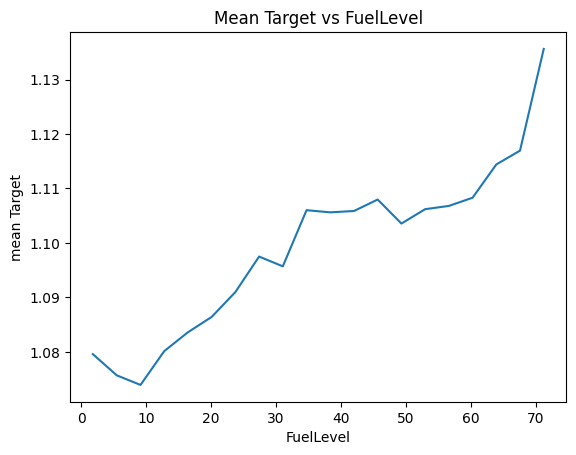

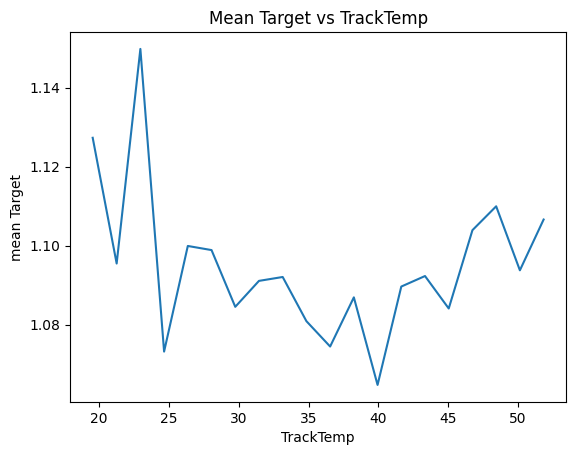

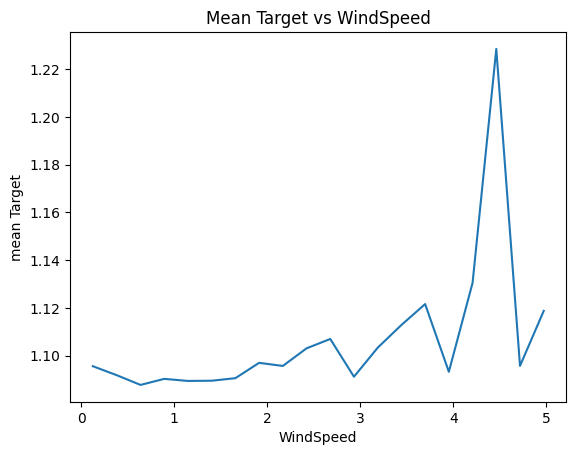

In [208]:
def trend(df, xcol, ycol="Target", bins=20, title=None):
    b = pd.cut(df[xcol], bins=bins)
    g = df.groupby(b, observed=True)[ycol].agg(["mean","count"])
    x = b.cat.categories.mid

    plt.figure()
    plt.plot(x, g["mean"].values)
    plt.title(f"Mean {ycol} vs {xcol}")
    plt.xlabel(xcol)
    plt.ylabel(f"mean {ycol}")
    plt.show()

trend(df, "FuelLevel")
trend(df, "TrackTemp")
trend(df, "WindSpeed")  

           FuelLevel  LapNumber   SpeedST  TyreLife  TrackTemp  WindSpeed  \
FuelLevel   1.000000  -0.897419 -0.104661 -0.414631   0.201299   0.184018   
LapNumber  -0.897419   1.000000 -0.048162  0.455880  -0.005529  -0.168451   
SpeedST    -0.104661  -0.048162  1.000000 -0.055109   0.131183   0.027950   
TyreLife   -0.414631   0.455880 -0.055109  1.000000  -0.022240  -0.080409   
TrackTemp   0.201299  -0.005529  0.131183 -0.022240   1.000000   0.033960   
WindSpeed   0.184018  -0.168451  0.027950 -0.080409   0.033960   1.000000   
Target      0.486972  -0.344533 -0.291239 -0.039822   0.120949   0.157229   

             Target  
FuelLevel  0.486972  
LapNumber -0.344533  
SpeedST   -0.291239  
TyreLife  -0.039822  
TrackTemp  0.120949  
WindSpeed  0.157229  
Target     1.000000  


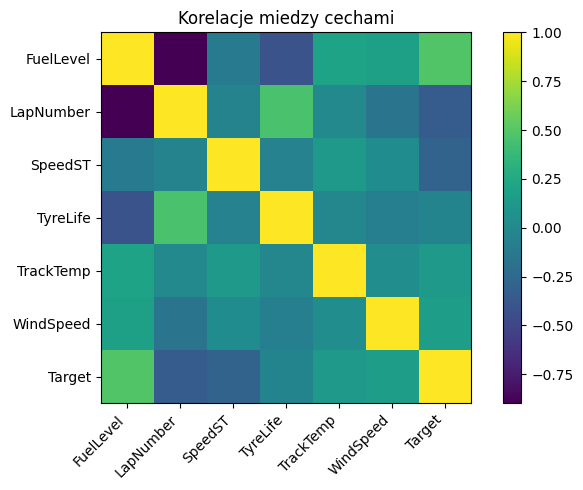

In [209]:
cols = ["FuelLevel","LapNumber","SpeedST","TyreLife","TrackTemp","WindSpeed","Target"]
C = df[cols].corr(method="spearman", numeric_only=True)
print(C)

plt.figure(figsize=(7,5))
plt.imshow(C, interpolation="nearest")
plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.yticks(range(len(cols)), cols)
plt.colorbar()
plt.title("Korelacje miedzy cechami")
plt.tight_layout()
plt.show()

df.drop(columns= "LapNumber", inplace=True)

Korelacje globalnie:
- Fuelevel dodatnie: wiecej paliwa -> wolniej
- TyreLife globalnie słabe

In [210]:
def per_round(df, col):
    out = []
    for rnd, g in df.groupby("RoundNumber"):
        r = g[[col, "Target"]].corr(method="spearman").iloc[0,1]
        out.append((rnd, r))
    return pd.DataFrame(out, columns=["RoundNumber", "Spearman"]).dropna()

for c in ["FuelLevel","SpeedST","TrackTemp","WindSpeed"]:
    t = per_round(df, c)
    print(c, "median:", t["Spearman"].median(), "mean:", t["Spearman"].mean(), "n_rounds:", len(t))

FuelLevel median: 0.6258454348319443 mean: 0.6217403848793466 n_rounds: 23
SpeedST median: 0.016608445711898873 mean: -0.017126816618609434 n_rounds: 23
TrackTemp median: 0.42946109378181185 mean: 0.3996282764952461 n_rounds: 23
WindSpeed median: 0.09359190134061518 mean: 0.07722906814992685 n_rounds: 23


Korelacje per round:
- FuelLevel i Tracktemp wysoko
- SpeedST globalnie wysoko, tutaj nisko (czyli zalezne od toru)

In [211]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge

y = df["Target"].values
X = df.drop(columns=["LapTime", "Target", "QualiBest", "RoundNumber"], errors="ignore")

groups = df["RoundNumber"].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

qb_test = df.iloc[test_idx]["QualiBest"].values
lt_test = df.iloc[test_idx]["LapTime"].values

In [212]:
# elementary baseline: always predict mean of target

mean_tr = y_train.mean()

pred_base_target = np.full_like(y_test, mean_tr)
print("Baseline MAE:", mean_absolute_error(y_test, pred_base_target))

pred_base_laptime = pred_base_target * qb_test
print("Baseline MAE (LapTime) [s]:", mean_absolute_error(lt_test, pred_base_laptime))

Baseline MAE: 0.03593444964691847
Baseline MAE (LapTime) [s]: 2.7199061467547003


In [213]:
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
])

ridge = Pipeline([
    ("pre", pre),
    ("model", Ridge(alpha=1.0, random_state=42))
])
ridge.fit(X_train, y_train)
pred_r = ridge.predict(X_test)
print("Ridge MAE:", mean_absolute_error(y_test, pred_r))

lt_pred = pred_r * qb_test
print("Ridge MAE(LapTime) [s]:", mean_absolute_error(lt_test, lt_pred))

Ridge MAE: 0.021562231813529457
Ridge MAE(LapTime) [s]: 1.6244786520391254


GroupShuffleSplit, bo jesli zrobimy zwykły losowy podział po wierszach to w train i test będą te same rundy i wynik bedzie zawyzony.

Przyklad:

In [214]:
from sklearn.model_selection import train_test_split

X2 = df.drop(columns=["LapTime","Target","QualiBest","RoundNumber"], errors="ignore")
y2 = df["Target"].values

Xtr, Xte, ytr, yte = train_test_split(X2, y2, test_size=0.2, random_state=42)
ridge.fit(Xtr, ytr)
pred = ridge.predict(Xte)
print("Random split MAE:", mean_absolute_error(yte, pred))
print("Group split  MAE:", mean_absolute_error(y_test, pred_r))

Random split MAE: 0.013655480346890687
Group split  MAE: 0.021562231813529457
